In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score
import gc
import time
import os
from typing import List, Optional

In [2]:
# Load data
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def load_cicids_data(folder_path: str,
                     chunksize: int = 100000) -> pd.DataFrame:
    """
    Load CICIDS2017 dataset in a memory-efficient manner.

    Args:
        folder_path: Path to the folder containing CSV files
        usecols: List of columns to load (None loads all columns)
        chunksize: Number of rows to read at a time

    Returns:
        Combined DataFrame with all data
    """
    # List to store DataFrames
    combined_df = None

    # Load the datasets
    for dirname, _, filenames in os.walk(folder_path):
        for filename in filenames:
            if filename.endswith('.csv'):
                file_path = os.path.join(dirname, filename)

                # Get total rows in file
                total_rows = sum(1 for _ in open(file_path)) - 1
                print(f"\nProcessing {filename} ({total_rows:,} rows)")

                # Read file in chunks
                chunk_iterator = pd.read_csv(
                    file_path,
                    chunksize=chunksize,
                    low_memory=True
                )

                for i, chunk in enumerate(chunk_iterator):
                    # Process chunk
                    if combined_df is None:
                        combined_df = chunk
                    else:
                        combined_df = pd.concat([combined_df, chunk], ignore_index=True)

                    # Print progress
                    rows_processed = min((i + 1) * chunksize, total_rows)
                    print(f"Progress: {rows_processed:,}/{total_rows:,} rows", end='\r')

                    # Force garbage collection
                    gc.collect()

                print(f"\nCompleted {filename}")

    return combined_df

# Usage example
folder_path = '/content/drive/MyDrive/Capstone /CICIDS2017'


# Load data efficiently
data = load_cicids_data(
    folder_path=folder_path,
    chunksize=100000
)


Processing Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv (225,745 rows)
Progress: 225,745/225,745 rows
Completed Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv

Processing Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv (286,467 rows)
Progress: 286,467/286,467 rows
Completed Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv

Processing Friday-WorkingHours-Morning.pcap_ISCX.csv (191,033 rows)
Progress: 191,033/191,033 rows
Completed Friday-WorkingHours-Morning.pcap_ISCX.csv

Processing Monday-WorkingHours.pcap_ISCX.csv (529,918 rows)
Progress: 529,918/529,918 rows
Completed Monday-WorkingHours.pcap_ISCX.csv

Processing Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv (288,602 rows)
Progress: 288,602/288,602 rows
Completed Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv

Processing Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv (170,366 rows)
Progress: 170,366/170,366 rows
Completed Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv

Proce

In [4]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
print(f"Dataset Dimensions: {data.shape}")

Dataset Dimensions: (2830743, 79)


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [22]:
def optimize_dtypes(df):
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        elif df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
    return df

data = optimize_dtypes(data)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int32  
 1    Flow Duration                int32  
 2    Total Fwd Packets            int32  
 3    Total Backward Packets       int32  
 4   Total Length of Fwd Packets   int32  
 5    Total Length of Bwd Packets  int32  
 6    Fwd Packet Length Max        int32  
 7    Fwd Packet Length Min        int32  
 8    Fwd Packet Length Mean       float32
 9    Fwd Packet Length Std        float32
 10  Bwd Packet Length Max         int32  
 11   Bwd Packet Length Min        int32  
 12   Bwd Packet Length Mean       float32
 13   Bwd Packet Length Std        float32
 14  Flow Bytes/s                  float32
 15   Flow Packets/s               float32
 16   Flow IAT Mean                float32
 17   Flow IAT Std                 float32
 18   Flow IAT Max         

In [7]:
# Checking for missing values
missing_values = data.isna().sum()
missing_percentage = (missing_values / len(data)) * 100

# Printing columns with missing values
for column, count in missing_values.items():
    if count != 0:
        print(f"Column '{column}' has {count} missing values, which is {missing_percentage[column]:.2f}% of the total")

Column 'Flow Bytes/s' has 1358 missing values, which is 0.05% of the total


In [8]:
# Removal of leading/trailing whitespace
col_names = {col: col.strip() for col in data.columns}
data.rename(columns = col_names, inplace = True)

In [10]:
duplicate_count = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count:,}")

Number of duplicate rows: 308,381


In [11]:
data = data.drop_duplicates(keep='first')
gc.collect()

180

In [12]:
data.shape

(2522362, 79)

In [13]:
# Identify columns with identical data
identical_columns = {}
columns = data.columns
list_control = columns.copy().tolist()

# Compare each pair of columns
for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            if data[col1].equals(data[col2]):
                if (col1 not in identical_columns) and (col1 in list_control):
                    identical_columns[col1] = [col2]
                    list_control.remove(col2)
                elif (col1 in identical_columns) and (col1 in list_control):
                    identical_columns[col1].append(col2)
                    list_control.remove(col2)

# Print the result
if identical_columns:
    print("Identical columns found:")
    for key, value in identical_columns.items():
        print(f"'{key}' is identical to {value}")
else: print("No identical columns found.")

Identical columns found:
'Total Fwd Packets' is identical to ['Subflow Fwd Packets']
'Total Backward Packets' is identical to ['Subflow Bwd Packets']
'Fwd PSH Flags' is identical to ['SYN Flag Count']
'Bwd PSH Flags' is identical to ['Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
'Fwd URG Flags' is identical to ['CWE Flag Count']
'Fwd Header Length' is identical to ['Fwd Header Length.1']


In [14]:
# Removing the columns with duplicated values
for key, value in identical_columns.items():
    data.drop(columns=value, inplace=True)

In [15]:
print(data.columns)
data.shape

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', 'RST Flag Count',
       'PSH Flag C

(2522362, 67)

In [16]:
num_columns = data.select_dtypes(include=np.number).columns

# Check for infinite values
inf_counts = np.isinf(data[num_columns]).sum()
inf_columns = inf_counts[inf_counts > 0]

if not inf_columns.empty:
    print("\nInfinite values found in:")
    for col, count in inf_columns.items():
        print(f"{col}: {count:,} infinite values")

    # Replace infinite values with NaN
    data = data.replace([np.inf, -np.inf], np.nan)
else:
    print("\nNo infinite values found.")


Infinite values found in:
Flow Bytes/s: 1,211 infinite values
Flow Packets/s: 1,564 infinite values


In [17]:
# Attack counts
attack_counts = data['Label'].value_counts().reset_index()
attack_counts.columns = ['Attack Type', 'Number of Occurrences']

# Duplicating the df and dropping rows with missing values
data_no_na = data.dropna()

# Counting the total number of occurrences of each attack after dropping
occurrences_nonull = data_no_na['Label'].value_counts().reset_index()
occurrences_nonull.columns = ['Attack Type', 'Occurrences w/o Null Rows']

# Merging the DataFrames
attack_counts = attack_counts.merge(occurrences_nonull, on='Attack Type', how='left')

# Calculating the difference
attack_counts['Abs Difference'] = attack_counts['Number of Occurrences'] - attack_counts['Occurrences w/o Null Rows']
attack_counts['Difference %'] = ((attack_counts['Abs Difference'] * 100) / attack_counts['Number of Occurrences']).round(2)

# Visualization
attack_counts

,Attack Type,Number of Occurrences,Occurrences w/o Null Rows,Abs Difference,Difference %
0,BENIGN,2096484,2095057,1427,0.07
1,DoS Hulk,172849,172846,3,0.00
2,DDoS,128016,128014,2,0.00
3,PortScan,90819,90694,125,0.14
4,DoS GoldenEye,10286,10286,0,0.00
5,FTP-Patator,5933,5931,2,0.03
6,DoS slowloris,5385,5385,0,0.00
7,DoS Slowhttptest,5228,5228,0,0.00
8,SSH-Patator,3219,3219,0,0.00
9,Bot,1953,1948,5,0.26


In [18]:
# Cleaning up
del data_no_na

# Evaluating percentage of missing values per column
threshold = 10
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Filter columns with missing values over the threshold
high_missing_cols = missing_percentage[missing_percentage > threshold]

# Print columns with high missing percentages
if len(high_missing_cols) > 0:
    print(f'The following columns have over {threshold}% of missing values:')
    print(high_missing_cols)
else:
    print('There are no columns with missing values greater than the threshold')

There are no columns with missing values greater than the threshold


In [19]:
row_missing_percentage = (data.isna().sum(axis=1) / data.shape[1]) * 100
print(row_missing_percentage.describe())

missing_rows = data.isna().any(axis=1).sum()
print(f'\nTotal rows with missing values: {missing_rows}')

count    2.522362e+06
mean     1.850907e-03
std      7.430795e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.985075e+00
dtype: float64

Total rows with missing values: 1564


In [20]:
# Dropping missing values
data = data.dropna()
print(f'Dataset shape after row-wise removal: {data.shape}')

Dataset shape after row-wise removal: (2520798, 67)


In [21]:
# Check for numeric columns that contain only a single unique value, indicating no diversity in values.
# Such columns contribute no useful information to the analysis and may be candidates for removal.
only_unique_cols = []
for col in data.columns:
    if len(data[col].unique()) == 1:
        only_unique_cols.append(col)
        print(col)

print(f'\nThe number of columns with only one unique values is: {len(only_unique_cols)}')

Bwd PSH Flags

The number of columns with only one unique values is: 1


In [22]:
# Dropping the columns with only one unique value
data.drop(only_unique_cols, axis=1, inplace=True)
del only_unique_cols

In [23]:
data.shape

(2520798, 66)

In [24]:
# Mapping the attacks to the new group
group_mapping = {
    'BENIGN': 'BENIGN',
    'DoS Hulk': 'DoS',
    'DDoS': 'DDoS',
    'PortScan': 'RECONNAISSANCE',
    'DoS GoldenEye': 'DoS',
    'FTP-Patator': 'BRUTE_FORCE',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'SSH-Patator': 'BRUTE_FORCE',
    'Bot': 'BOTNET',
    'Web Attack � Brute Force': 'WEB_ATTACK',
    'Web Attack � XSS': 'WEB_ATTACK',
    'Infiltration': 'WEB_ATTACK',
    'Web Attack � Sql Injection': 'WEB_ATTACK',
    'Heartbleed': 'WEB_ATTACK'
}

# Map to new group column
data['Attack Type'] = data['Label'].map(group_mapping)
print(data['Attack Type'].unique())

['BENIGN' 'DDoS' 'RECONNAISSANCE' 'BOTNET' 'WEB_ATTACK' 'BRUTE_FORCE'
 'DoS']


In [25]:
# Checking the new values
data['Attack Type'].value_counts()

,count
Attack Type,
BENIGN,2095057
DoS,193745
DDoS,128014
RECONNAISSANCE,90694
BRUTE_FORCE,9150
WEB_ATTACK,2190
BOTNET,1948


In [26]:
# Dropping the old 'Label' column
data.drop(columns='Label', inplace=True)

In [27]:
from sklearn.model_selection import train_test_split
X = data.drop(columns='Attack Type')
y = data['Attack Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import time

start_fit = time.time()

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
end_fit = time.time()
print(f"Training time: {end_fit - start_fit:.2f} seconds")
rf_fit_t = end_fit - start_fit

start_pred = time.time()
y_pred = rf.predict(X_test)
end_pred = time.time()
print(f"Prediction time: {end_pred - start_pred:.2f} seconds")
rf_pred_t = end_pred - start_pred

Training time: 1654.93 seconds
Prediction time: 18.01 seconds


In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=4))
rf_report = classification_report(y_test, y_pred, digits=4, output_dict=True)

                precision    recall  f1-score   support

        BENIGN     0.9989    0.9993    0.9991    837745
        BOTNET     0.8528    0.7687    0.8086       761
   BRUTE_FORCE     0.9995    0.9995    0.9995      3654
          DDoS     0.9999    0.9993    0.9996     51139
           DoS     0.9983    0.9968    0.9976     77851
RECONNAISSANCE     0.9900    0.9880    0.9890     36257
    WEB_ATTACK     0.9944    0.9639    0.9789       913

      accuracy                         0.9985   1008320
     macro avg     0.9762    0.9593    0.9674   1008320
  weighted avg     0.9985    0.9985    0.9985   1008320



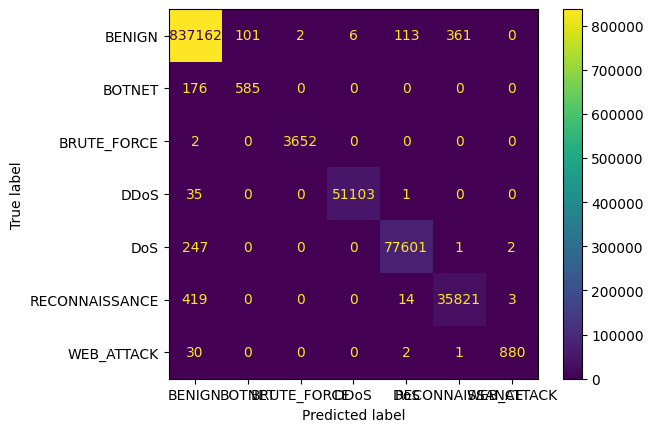

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
rf_confm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

# Perform k-fold cross-validation
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1_macro')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Compare with test set score
test_score = f1_score(y_test, y_pred, average='macro')
print(f"Test set score: {test_score:.4f}")

# If test_score is significantly higher than cv_scores.mean(),
# or cv_scores have high variance, this indicates overfitting

Cross-validation scores: [0.96465055 0.96707901 0.96465529 0.96762011 0.9597427 ]
Mean CV score: 0.9647 (+/- 0.0056)
Test set score: 0.9674


In [32]:
import joblib

# Save the model to a file
model_filename = 'intrusion_detection_model.joblib'
joblib.dump(rf, model_filename)
print(f"Model saved to {model_filename}")

Model saved to intrusion_detection_model.joblib


In [ ]:
import joblib

# Load the model from the file
model_filename = 'intrusion_detection_model.joblib'
loaded_model = joblib.load(model_filename)

# Now you can use the loaded model to make predictions
y_pred = loaded_model.predict(X_test)